In [43]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [44]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [45]:
# loads model + val/test set, evaluates accuracy

import torch
from model import build_model_r3d_18  # replace with actual class name
from dataset import ClipDataset
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import csv
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from datetime import datetime
import os





In [46]:
# ========== SETUP ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load test dataset
test_csv_path = "/home/atupulazi/personal_projects/collision-detection/frames/test/test_clip_labels.csv"  # <-- update if different
test_dataset = ClipDataset(test_csv_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [47]:
# Load model
model_name = "r3d_18"
model_path = f"checkpoints/{model_name}_best.pth"

model = build_model_r3d_18()
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Load extra metrics 9using 0s so if the keys dont exist we wont get error
epoch = checkpoint.get('epoch', 0)
avg_loss = checkpoint.get('avg_loss', 0.0)
val_acc = checkpoint.get('val_acc', 0.0)

summary(model, input_size=(3, 16, 112, 112))  # Example input shape: (C, D, H, W)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 16, 56, 56]          28,224
       BatchNorm3d-2       [-1, 64, 16, 56, 56]             128
              ReLU-3       [-1, 64, 16, 56, 56]               0
      Conv3DSimple-4       [-1, 64, 16, 56, 56]         110,592
       BatchNorm3d-5       [-1, 64, 16, 56, 56]             128
              ReLU-6       [-1, 64, 16, 56, 56]               0
      Conv3DSimple-7       [-1, 64, 16, 56, 56]         110,592
       BatchNorm3d-8       [-1, 64, 16, 56, 56]             128
              ReLU-9       [-1, 64, 16, 56, 56]               0
       BasicBlock-10       [-1, 64, 16, 56, 56]               0
     Conv3DSimple-11       [-1, 64, 16, 56, 56]         110,592
      BatchNorm3d-12       [-1, 64, 16, 56, 56]             128
             ReLU-13       [-1, 64, 16, 56, 56]               0
     Conv3DSimple-14       [-1, 64, 16,

In [48]:
# ========== TEST LOOP ==========
all_preds = []
all_labels = []

with torch.no_grad():
    for clips, labels in test_loader:
        clips, labels = clips.to(device), labels.to(device)
        outputs = model(clips)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

print(classification_report(
    all_preds.cpu().numpy(),
    all_labels.cpu().numpy(),
    target_names=['no_crash', 'crash']
))

              precision    recall  f1-score   support

    no_crash       0.61      0.80      0.70        61
       crash       0.85      0.69      0.76        99

    accuracy                           0.73       160
   macro avg       0.73      0.75      0.73       160
weighted avg       0.76      0.73      0.74       160



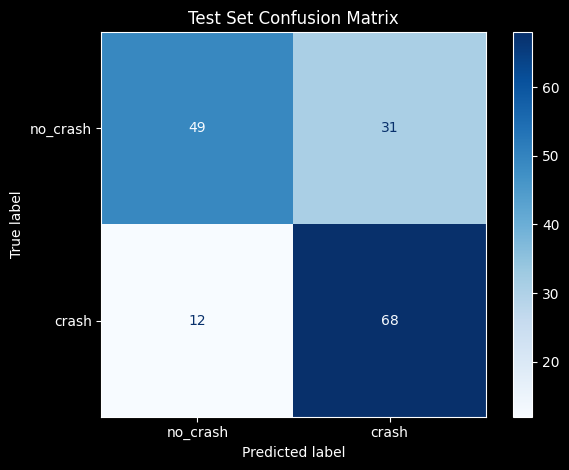

In [49]:
cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no_crash", "crash"])

disp.plot(cmap="Blues", values_format="d")
plt.title(f"Test Set Confusion Matrix")
plt.tight_layout()
plt.show()

In [50]:
# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# CSV file path
os.makedirs("test_metrics", exist_ok=True)
csv_path = f"test_metrics/test_metrics{timestamp}.csv"
write_header = not os.path.exists(csv_path)

# Write to CSV
with open(csv_path, mode='a', newline='') as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow(["Accuracy", "Precision", "Recall", "F1", "Timestamp"])
    writer.writerow([f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}", timestamp])
